In [1]:
def load_data(input_data_dir:str): 

    from torch.utils.data import DataLoader
    import os 
    import numpy as np
    import torch
    import rasterio 
    from PIL import Image
    from PIL import ImageFile
    from sklearn.model_selection import train_test_split
    from torchvision import transforms
    from torch.utils.data import TensorDataset, DataLoader
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    annotations = [os.path.join(input_data_dir, f'extracted_annotation_{i}.png') for i in range(4)]
    boundaries = [i.replace('extracted_annotation', 'extracted_boundary') for i in annotations]
    ndvi_images = [i.replace('extracted_annotation', 'extracted_ndvi') for i in annotations]
    pan_images = [i.replace('extracted_annotation', 'extracted_pan') for i in annotations]

    #trans = transforms.Compose([transforms.ToTensor()])

    dim = rasterio.open(ndvi_images[0]).read().shape[1:]

    X = np.zeros(shape=(len(ndvi_images), 2, dim[-2], dim[-1])) # (N, C, H, W)
    y = np.zeros(shape=(len(ndvi_images), 1, dim[-2], dim[-1])) # nice! more efficient...NOTE: used to be 2*dim[-1] for this W to account for weights, but to simplify, I'm just doing annotation on output for now. issue I need to fix later. 

    for i in range(len(ndvi_images)):
        ndvi_img = rasterio.open(ndvi_images[i])
        pan_img = rasterio.open(pan_images[i])
        read_ndvi_img = ndvi_img.read()
        read_pan_img = pan_img.read()

        # y would have two channels, i.e. annotations and weights.
        comb_img = np.concatenate((read_ndvi_img, read_pan_img), axis=0)
        #print(comb_img.shape)
        #comb_img = np.transpose(comb_img, axes=(1,2,0)) # original channel was at the end, but I'm putting it towards the begginning to fit pytorch practice? 
        # 
        annotation_im = Image.open(annotations[i])
        annotation = np.array(annotation_im)
        annotation[annotation<0.5] = 0
        annotation[annotation>=0.5] = 1
        
        #boundaries have a weight of 10 other parts of the image has weight 1
        weight_im = Image.open(boundaries[i])
        weight = np.array(weight_im)
        weight[weight>=0.5] = 10
        weight[weight<0.5] = 1

        #ann_joint = np.concatenate((annotation,weight), axis=-1) # why does it create them as next to each other left/right? 
        #print(ann_joint.shape)

        X[i] = comb_img
        y[i] = annotation #ann_joint

    # 2. Split into train / validation partitions
    test_size = 0.1
    val_size = 0.2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
    
    # 3. Create data loaders
    batch_size = 1
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True) # os.cpu_count()
    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), shuffle=True, **loader_args) # Yikes this is messy. clean later. 
    val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val)), shuffle=False, **loader_args)
    test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), shuffle=False, **loader_args)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data('/Users/yaroslav/Documents/Work/NASA/old/data/first-annotations-push/first-shadows-dataset/')


In [2]:
from torchsummary import summary # used to be torchsummary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(6)
model = model.to(device)

summary(model, input_size=(2, 1056, 1056))# input_size=(channels, H, W))

# expects the input to have size [batch_size, channels, depth, height, width] 
# batch_size: 
# channels: 2 for ndvi and pan 
# depth: 

In [ ]:
z = next(iter(train_loader))[1]
z[0].shape

print(sum([1 for _ in train_loader]))
print(sum([1 for _ in val_loader]))
print(sum([1 for _ in test_loader]))

2
1
1


In [ ]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss
import time
import copy

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            if phase == 'train':
                dataloader = train_loader
            else: 
                dataloader = val_loader

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 2 # maybe num class was the problem? it was 6 before, and I just changed it to 2, and it seems to be working haha. 

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=2)

cpu
Epoch 0/1
----------
LR 0.0001


/opt/homebrew/Caskroom/miniconda/base/envs/cnnheights38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


ValueError: Target size (torch.Size([1, 1, 1056, 1056])) must be the same as input size (torch.Size([1, 2, 1056, 1056]))

In [ ]:
# prediction

import math

model.eval()   # Set model to evaluate mode
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

print(pred)

(1, 2, 1056, 1056)
[[[[0.06341933 0.06046014 0.05992556 ... 0.06275646 0.06235326
    0.06639054]
   [0.05638496 0.05197485 0.05068319 ... 0.05449297 0.05727006
    0.06311986]
   [0.05341524 0.05014117 0.04844893 ... 0.05173644 0.05648913
    0.06238355]
   ...
   [0.05237352 0.04829649 0.0491778  ... 0.03696436 0.04687987
    0.05768156]
   [0.05564807 0.04988114 0.04927474 ... 0.03982889 0.04670389
    0.05629816]
   [0.05961132 0.0569389  0.05802898 ... 0.05681087 0.05947832
    0.06165211]]

  [[0.01810053 0.01455061 0.01208924 ... 0.01733197 0.01821449
    0.02089809]
   [0.01899796 0.01298634 0.01057318 ... 0.01271977 0.01577337
    0.0197184 ]
   [0.01923286 0.01193587 0.00888657 ... 0.01125805 0.01307428
    0.01781018]
   ...
   [0.01897347 0.01093581 0.00958018 ... 0.00202455 0.00136207
    0.00436348]
   [0.02214521 0.01494952 0.0134328  ... 0.00501935 0.00539461
    0.00757993]
   [0.02288925 0.01564689 0.01581341 ... 0.00636899 0.00629686
    0.01373916]]]]


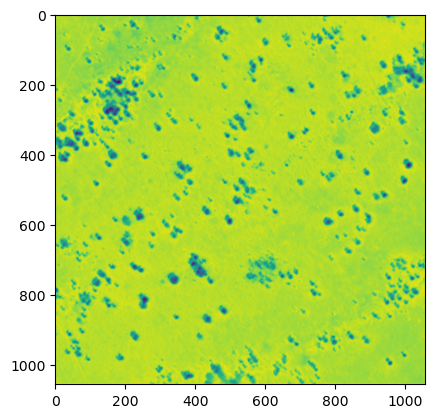

In [ ]:
import matplotlib.pyplot as plt 

plt.imshow(pred[0][0])
plt.imshow(pred[0][1])